# Bootstrap Solution

Simpler approach to fit the data by sequentially adding the spin that makes the resulting set be the one most similar to the signal.

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
# This functionalizes the fit that Michael used.

guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
the_pipe = (lambda features: guess_clf.predict(guess_scaler.transform([features])))

def carbon_fit(diamond, guess_classifier, x_threshold):
    #guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
    #guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
    #Initialize results lists and others
    num_correct_list, num_incorrect_list = [], []
    As_list, Bs_list = [], []
    guess_As_list, guess_Bs_list = [], []
    dips_measured = []
    
    #print "diamond_ind: ", diamond_ind
    #diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]

    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = x_threshold, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    A3 = np.copy(np.array(cluster_As));
    B3 = np.copy(np.array(cluster_Bs));
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct
    return {'A':As, 'B':Bs}

In [80]:
# This imports the csv with the set of possible A,B values.
# The units are in kHz, thus the conversion to rad/s.
all_options = analysis.mag*np.genfromtxt('complete_lattice.csv',delimiter=',');

In [26]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [346]:
# import a test dataset
sample = learning.load_obj_2('./diamonds/diamond_3')
data = sample['data'] # grab the data out of the dictionary

In [347]:
the_final_fit = carbon_fit(sample,the_pipe,1.0) # This gives the classical fit

dips measured:  382
num_removed:  1
correct:  15 incorrect:  1


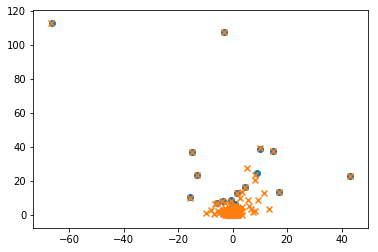

In [348]:
plt.figure()
plt.scatter(the_final_fit['A']/analysis.mag,the_final_fit['B']/analysis.mag)
plt.scatter(sample['A']/analysis.mag,np.abs(sample['B'])/analysis.mag,marker='x')
plt.show()

In [349]:
# This would be the noiseless signal from the
# ground truth values of As and Bs.
true_M=analysis.calc_M(sample['A'],sample['B'],sample['N'],omega_larmor,sample['tau'])

In [350]:
# This gives the signal as recovered
# by the values for As and Bs found
# by carbon_fit.
fitted_M_ML = analysis.calc_M(the_final_fit['A'],the_final_fit['B'],sample['N'],omega_larmor,sample['tau'])

In [353]:
# This defines the function to asses the similarity
# between two signal. It's what the literature calls
# cosine similarity.
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [373]:
# In here the bootstrap is applied.
# Each round takes about 80s.
#%%time
current_fit = np.ones(len(sample['data']))
fitted_As=[]
fitted_Bs=[]
remaining_options = np.copy(all_options)
counter_3 = 0
path_followed = []
best_resemblance = 0.
for counter_1 in range(20):
    closenesses=[]
    print("round "+str(counter_1))
    for counter_2 in range(len(remaining_options)):
        AB = remaining_options[counter_2] # Select the spin to be considered.
#         if (counter_2 % 200 == 0 and counter_1 > 0) or (counter_2 % 1000 == 0 and counter_1 == 0):
#             frac = int(float(counter_2)/len(remaining_options)*100.)
#             print(frac),
        ansatz = current_fit * analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,sample['tau']) # calculate the signal that would result if the new spin was added to it
        closenesses.append(closeness(ansatz, data)) # append the resulting closeness to the list that stores them all
    max_closenesses_index = np.argmax(closenesses) # Find the index for the spin that gave the greater similarity
    best_resemblance = closenesses[max_closenesses_index]
    if closenesses[max_closenesses_index] >= best_resemblance:
        print('Going uphill')
    else:
        print('Going downhill')
    best_A = remaining_options[max_closenesses_index][0]
    best_B = remaining_options[max_closenesses_index][1]
    print("best = "+str(best_resemblance))
    path_followed.append(best_resemblance) # Append the best closeness
    fitted_As.append(remaining_options[max_closenesses_index][0]) # Append the best A
    fitted_Bs.append(remaining_options[max_closenesses_index][1]) # Append the best B
    current_fit = current_fit * analysis.calc_M_single(best_A,best_B,64, omega_larmor,sample['tau']) # Calculate the updated fit for M
    if False and (counter_1 == 0): # Enable this to eliminate most spins on end of firs iteration. This was not enabled for the plot showed in the report.
        remaining_options = remaining_options[np.argsort(closenesses)[-5000:]]
    else:
        remaining_options=np.delete(remaining_options,max_closenesses_index,axis=0) # Eliminate the best spin from the set of possible options.
    

round 0
Going uphill
best = 0.854945079092
round 1
Going uphill
best = 0.872209588323
round 2
Going uphill
best = 0.884902718187
round 3
Going uphill
best = 0.895534683061
round 4
Going uphill
best = 0.904954732036
round 5
Going uphill
best = 0.914071335752
round 6
Going uphill
best = 0.922702876061
round 7
Going uphill
best = 0.93125893163
round 8
Going uphill
best = 0.938542922198
round 9
Going uphill
best = 0.944117206463
round 10
Going uphill
best = 0.949620891464
round 11
Going uphill
best = 0.9539039325
round 12
Going uphill
best = 0.957753255272
round 13
Going uphill
best = 0.960782550974
round 14
Going uphill
best = 0.963609825135
round 15
Going uphill
best = 0.9660910086
round 16
Going uphill
best = 0.968487034168
round 17
Going uphill
best = 0.970476844721
round 18
Going uphill
best = 0.971856921329
round 19
Going uphill
best = 0.973146621614


In [374]:
os.system('beep 100')

2

In [359]:
#hey=pickle.load(open('bootstrap.pkl','rb'))
# pickle.dump({'conditions':'Total bootstrap, sample diamond2.',
#              'path followed':hey['path followed'],
#              'fitted_As':hey['fitted_As'],
#              'fitted_Bs':hey['fitted_Bs'],
#              'current_fit':hey['current_fit']},open('bootstrap.pkl','wb'))

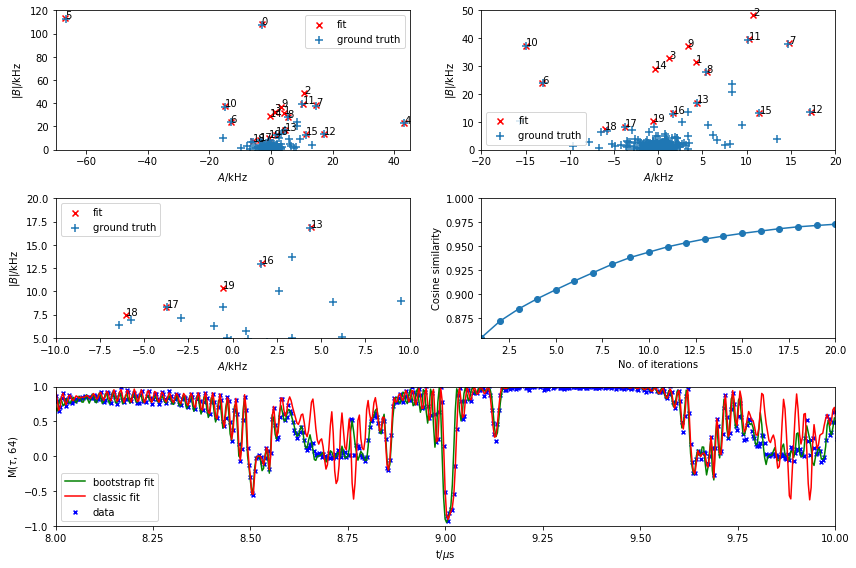

In [454]:
plt.figure(figsize=(12,8))
plt.subplot(3,2,1)
Abounds=np.array([-70,45]);
Bbounds=np.array([0,120]);
plt.scatter(np.array(fitted_As)/analysis.mag,np.abs(np.array(fitted_Bs))/analysis.mag,label='fit',marker='x',color='red')
#plt.scatter(all_options[:,0]/analysis.mag,np.abs(all_options[:,1])/analysis.mag,c='k',s=1,label='all')
for counter in range(len(fitted_As)):
    if (np.array(fitted_As[counter])/analysis.mag<Abounds[1]) \
    and (np.array(fitted_As[counter])/analysis.mag>Abounds[0]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag<Bbounds[1]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag>Bbounds[0]):
        plt.text(np.array(fitted_As[counter])/analysis.mag,
                 np.abs(np.array(fitted_Bs[counter]))/analysis.mag,
                str(counter))
plt.scatter(sample['A']/analysis.mag,np.abs(sample['B'])/analysis.mag,marker='+',label='ground truth',s=70)
plt.xlim(Abounds[0],Abounds[1])
plt.ylim(Bbounds[0],Bbounds[1])
plt.xlabel('$A$/kHz')
plt.ylabel('$|B|$/kHz')
plt.legend()
plt.subplot(3,2,2)
Abounds=np.array([-20,20]);
Bbounds=np.array([0,50]);
plt.scatter(np.array(fitted_As)/analysis.mag,np.abs(np.array(fitted_Bs))/analysis.mag,label='fit',marker='x',color='red')
#plt.scatter(all_options[:,0]/analysis.mag,np.abs(all_options[:,1])/analysis.mag,c='k',s=1,label='all')
for counter in range(len(fitted_As)):
    if (np.array(fitted_As[counter])/analysis.mag<Abounds[1]) \
    and (np.array(fitted_As[counter])/analysis.mag>Abounds[0]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag<Bbounds[1]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag>Bbounds[0]):
        plt.text(np.array(fitted_As[counter])/analysis.mag,
                 np.abs(np.array(fitted_Bs[counter]))/analysis.mag,
                str(counter))
plt.scatter(sample['A']/analysis.mag,np.abs(sample['B'])/analysis.mag,marker='+',label='ground truth',s=70)
plt.xlim(Abounds[0],Abounds[1])
plt.ylim(Bbounds[0],Bbounds[1])
plt.xlabel('$A$/kHz')
plt.ylabel('$|B|$/kHz')
plt.legend()
plt.subplot(3,2,3)
Abounds=np.array([-10,10]);
Bbounds=np.array([5,20]);
plt.scatter(np.array(fitted_As)/analysis.mag,np.abs(np.array(fitted_Bs))/analysis.mag,label='fit',marker='x',color='red')
#plt.scatter(all_options[:,0]/analysis.mag,np.abs(all_options[:,1])/analysis.mag,c='k',s=1,label='all')
for counter in range(len(fitted_As)):
    if (np.array(fitted_As[counter])/analysis.mag<Abounds[1]) \
    and (np.array(fitted_As[counter])/analysis.mag>Abounds[0]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag<Bbounds[1]) \
    and (np.abs(np.array(fitted_Bs[counter]))/analysis.mag>Bbounds[0]):
        plt.text(np.array(fitted_As[counter])/analysis.mag,
                 np.abs(np.array(fitted_Bs[counter]))/analysis.mag,
                str(counter))
plt.scatter(sample['A']/analysis.mag,np.abs(sample['B'])/analysis.mag,marker='+',label='ground truth',s=70)
plt.xlim(Abounds[0],Abounds[1])
plt.ylim(Bbounds[0],Bbounds[1])
plt.xlabel('$A$/kHz')
plt.ylabel('$|B|$/kHz')
plt.legend()

plt.subplot(3,2,4)

plt.plot(range(1,len(path_followed)+1),path_followed,'o-')
# for jack in jackpot:
#     plt.plot([jackpot,jackpot],[0,1])
plt.xlabel('No. of iterations')
plt.ylabel('Cosine similarity')
#plt.ylim(0,1)
plt.xlim(1,len(path_followed))
plt.ylim(min(np.array(path_followed)),1)


plt.subplot(3,1,3)

plt.scatter(10**6*sample['tau'],data,color='b',marker='x',s=15,lw=1.5,label='data')
plt.plot(10**6*sample['tau'],current_fit,'g',lw=1.5,label='bootstrap fit')
plt.plot(10**6*sample['tau'],fitted_M_ML,'r',label='classic fit')
plt.xlim(8,10)
plt.xlabel('t/$\mu$s')
plt.ylabel('M($\\tau$, 64)')
plt.ylim(-1,1)
plt.legend()

plt.tight_layout()
plt.savefig(fig_dir+'boot_panel.png',dpi=100)
plt.savefig(fig_dir+'boot_panel.png',dpi=100)
plt.savefig(fig_dir+'boot_panel.pdf')
plt.show()

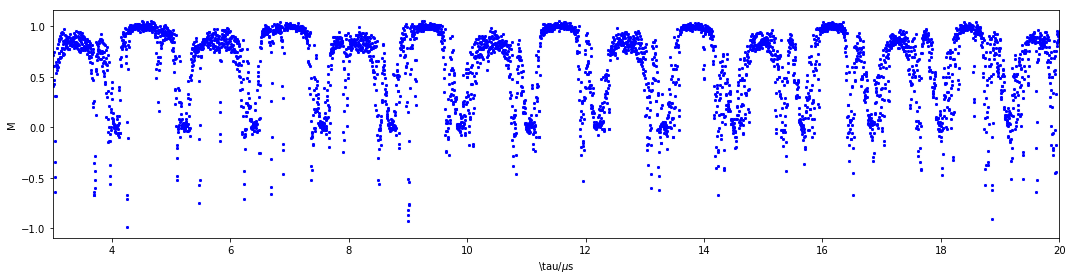

In [462]:
# This is tangential to the main purpose of this notebook.
# A plot of a sample signal for M.

plt.figure(figsize=(15,4))
plt.scatter(10**6*sample['tau'],data,color='b',marker='x',s=5,lw=1.5,label='data')
plt.xlabel('\\tau/$\mu$s')
plt.ylabel('M')
plt.xlim(3,20)
plt.tight_layout()
plt.savefig(fig_dir+'example_M.png',dpi=100)
plt.savefig(fig_dir+'example_M.png',dpi=100)
plt.savefig(fig_dir+'example_M.pdf')
plt.show()

In [451]:
# How close this the classical fit get?
closeness(fitted_M_ML,data)

0.96585182381597157

In [408]:
current_fit_calculated=analysis.calc_M(np.array(fitted_As[0:]),np.array(fitted_Bs[0:]),64,omega_larmor,sample['tau'])

In [327]:
fig_dir='/Users/juan/Google Drive/Brown/2017S/Machine Learning Applied to Scientific Data  - ENGN2912Z/NV-Tomography/';

In [334]:
no_noise=analysis.calc_M(sample['A'],sample['B'],64,omega_larmor,sample['tau'])

In [411]:
closeness(current_fit_calculated,data)

0.97314662161370435

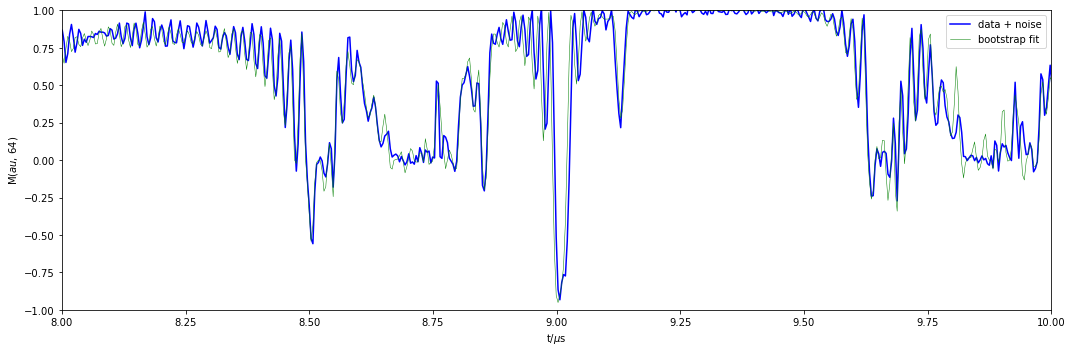

In [418]:
plt.figure(figsize=(15,5))
plt.plot(10**6*sample['tau'],data,'b',lw=1.5,label='data + noise')
plt.plot(10**6*sample['tau'],current_fit,'g',lw=0.5,label='bootstrap fit')
plt.xlim(8,10)
plt.xlabel('t/$\mu$s')
plt.ylabel('M($\tau$, 64)')
plt.ylim(-1,1)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir+'bootstrap-1.png',dpi=100)
plt.savefig(fig_dir+'bootstrap-1.jpg',dpi=100)
plt.savefig(fig_dir+'bootstrap-1.pdf')
plt.show()

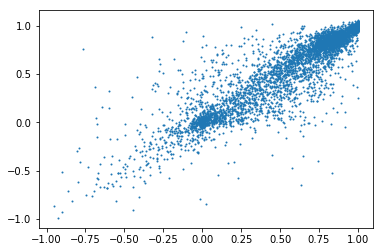

In [440]:
plt.figure()
plt.scatter(current_fit,data,s=1)
plt.show()